# Sampling Methods

In Machine Learning, we often deal with *complex probability distributions*, which require us to estimate expectations, compute difficult integrals, and draw samples. For many probabilistic models of practical interest we find out that analytical solutions are intractable, and we have to resort to *approximations*: in this context, sampling methods provide a powerful set of tools to approximate such computations through random sampling.

In many applications, we are not directly interested in the posterior distribution itself, but rather in using it to compute expectations, such as making predictions. Formally, we want to calculate the expected value of some function $f(z)$ under a probability distribution $p(z)$. This expectation is generally expressed as an integral for continuous variables (or a sum, for discrete variables): 
$$ E[f] = ∫ f(z) p(z) dz$$ 
As we said, in many cases this integral is too complex to compute analytically. This is where sampling methods come to our aid: the idea is to approximate this expectation by generating a set of *samples* $ L = z^{(1)}, ..., z^{(L)}$ drawn independently from the distribution $p(z)$, and then estimate the expectation as a simple average of these values: 
$$ \hat{f} = \frac{1}{L} ∑_{l=1}^L f(z^{(l)}) $$
This estimator is *unbiased*, meaning that its expected value equals the true expectation (i.e. $E[\hat{f}] = E[f]$) and its variance is given by:
$$var[\hat{f}] = \frac{1}{L} E[(f - E[f])^2]$$
Note that the accuracy of the estimator does not depend on the dimensionality of $z$, which means that, in practice, sometimes even 10 or 20 independent samples can lead to a sufficiently accurate result.

However, there are some challenges:
- The samples ${z^{(l)}}$ may not be independent, which reduces the real sample size.
- If $f(z)$ is small in regions where $p(z)$ is large, and vice versa, then the estimate may be dominated by regions of small probability (rare events), requiring many more samples to achieve sufficient accuracy.


***

## 1 - Basic Sampling Algorithms
In this section, we consider some simple methods for generating random samples
from a given distribution, assuming that we're using an algorithm that generates pseudo-random numbers distributed uniformly over $(0, 1)$.

### 1.1 - Standard Distributions

Let's start with discussing how to generate random numbers from simple nonuniform distributions.  

Suppose that $z$ is uniformly distributed over the interval $(0, 1)$,
we define a transformation function $f(·)$ such that $y = f(z)$ and the resulting 
$y$ values follow a specific desired distribution $p(y)$.

The relationship between the distributions of $z$ and $y$ is given by the formula $$p(y) = p(z)  |\frac{dz}{dy}| $$ where, in this case, $p(z)=1$, since $z∼Uniform(0,1)$.

Integrating $p(y)$, we obtain: $$z = h(y) = ∫_{-∞}^{y} p(\hat{y}) d\hat{y}$$

Calculating this indefinite integral gives us a function $h(y)$, which maps a value of $y$ to a uniform value $z$. 

To sample from $p(y)$, we invert this function: $$y = h^{-1}(z)$$

In other words, we have to transform the uniformly distributed random numbers $z$ using a function which is the inverse of the indefinite integral of the desired distribution.

This method works well when $h^{-1}$ is easy to compute; if that isn't the case, we need to rely on other techniques, such as the ones introduced in the following sections.

#### In Practice
The graphs in this section show the results of sampling from three widely used probability distributions: the Normal, Exponential and Beta distributions. Although NumPy provides built-in sampling functions, the function `inverse_transform_sample` defined below chooses a less refined approach by following step by step the process described in our last paragraph, from scratch. For each distribution, we perform Inverse Transform Sampling and visualize the sampled data along with the theoretical PDF.

Using Jupyter's interactive widgets (see [documentation](https://ipywidgets.readthedocs.io/en/latest/examples/Using%20Interact.html)) we can  experiment with different distribution parameters and observe how the sampled data behaves.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm, expon, beta
import ipywidgets as widgets
from IPython.display import display
from scipy.interpolate import interp1d

In [2]:
def inverse_transform_sample(pdf, z_min, z_max, n_samples=1000):

    z = np.linspace(z_min, z_max, 10000)
    pdf = pdf(z)  # Evaluate PDF in each z
    dz = z[1] - z[0]  # Distance between two consecutive values, to approximate the PDF integral with a sum
    cdf = np.cumsum(pdf) * dz  # Evaluate CDF using cumulative sum
    cdf = cdf / cdf[-1]  # Normalize to [0,1]

    # Compute the inverse using ScyPi's linear interpolation.
    # To avoid ValueErrors being raised, set 'bounds_error' to False
    # So that out of bounds values are assigned 'fill_value', i.e. the extreme values of the CDF
    inv_cdf = interp1d(cdf, z, bounds_error=False, fill_value=(z[0], z[-1]))

    # Generate n_samples uniform random values in (0, 1)
    u = np.random.uniform(0, 1, size=n_samples) 
    
    return inv_cdf(u)  

In [24]:
# Every time the parameters are changed from the widget, 
# 'plot' is called with the updated values
def plot_normal():
    @widgets.interact(mu=widgets.FloatSlider(value=0, min=-5, max=5, step=0.1 ,description='μ'),
                      sigma=widgets.FloatSlider(value=1, min=0.1, max=5, step=0.1, description='σ'),
                      n_samples=widgets.IntSlider(value=5000, min=100, max=10000, step=100, description='# samples'))
    def plot(mu, sigma, n_samples):

        # Set the approximated interval in which the PDF and the CDF will be evaluated 
        z_min = mu - 5*sigma
        z_max = mu + 5*sigma

        # Lambda function to define the PDF for a normal distribution
        # with current mean (mu) and standard deviation (sigma)
        pdf = lambda z: norm.pdf(z, loc=mu, scale=sigma)

        # Generate samples from the interval
        samples = inverse_transform_sample(pdf, z_min, z_max, n_samples)

        # Plotting code generated by ChatGPT
        z = np.linspace(z_min, z_max, 1000)
 
        plt.figure(figsize=(8, 4))
        plt.hist(samples, bins='auto', density=True, alpha=0.6, label='Sampled')
        plt.plot(z, pdf(z), 'r-', label=f'N({mu}, {sigma}²)')
        plt.title("Inverse Transform Sampling: Normal Distribution")
        plt.xlabel("z")
        plt.ylabel("Density")
        plt.legend()
        plt.grid(True)
        plt.show()

def plot_exponential():
    @widgets.interact(lmbda=widgets.FloatSlider(value=1.0, min=0.1, max=5.0, step=0.1, description='λ'),
                      n_samples=widgets.IntSlider(value=5000, min=100, max=10000, step=100, description='# samples'))
    def plot(lmbda, n_samples):
        z_min = 0
        z_max = 10
        
        # Lambda function to define the PDF for an exponential distribution
        pdf = lambda z: expon.pdf(z, scale=1/lmbda)
        samples = inverse_transform_sample(pdf, z_min, z_max, n_samples)
        
        z = np.linspace(z_min, z_max, 1000)
        
        plt.figure(figsize=(8, 4))
        plt.hist(samples, bins='auto', density=True, alpha=0.6, label='Sampled')
        plt.plot(z, pdf(z), 'r-', label=f'Exp(λ={lmbda})')
        plt.title("Inverse Transform Sampling: Exponential Distribution")
        plt.xlabel("z")
        plt.ylabel("Density")
        plt.legend()
        plt.grid(True)
        plt.show()

def plot_beta():
    @widgets.interact(a=widgets.FloatSlider(value=2.0, min=0.1, max=10.0, step=0.1),
                      b=widgets.FloatSlider(value=2.0, min=0.1, max=10.0, step=0.1),
                      n_samples=widgets.IntSlider(value=5000, min=100, max=10000, step=100, description='# samples'))
    def plot(a, b, n_samples):
        z_min = 0
        z_max = 1
        
        # Lambda function to define the PDF for a beta distribution
        pdf = lambda z: beta.pdf(z, a, b)
        samples = inverse_transform_sample(pdf, z_min, z_max, n_samples)
        
        z = np.linspace(z_min, z_max, 1000)
        
        plt.figure(figsize=(8, 4))
        plt.hist(samples, bins='auto', density=True, alpha=0.6, label='Sampled')
        plt.plot(z, pdf(z), 'r-', label=f'Beta({a}, {b})')
        plt.title("Inverse Transform Sampling: Beta Distribution")
        plt.xlabel("z")
        plt.ylabel("Density")
        plt.legend()
        plt.grid(True)
        plt.show()


In [25]:
plot_normal()

interactive(children=(FloatSlider(value=0.0, description='μ', max=5.0, min=-5.0), FloatSlider(value=1.0, descr…

We can observe how changing the mean (μ) and standard deviation (σ) affects the shape and position of the distribution. Increasing the mean shifts the bell curve to the right, while decreasing it moves it to the left. Instead, varying the standard deviation affects the spread: a larger $σ$ results in a wider and flatter bell curve, while a smaller $σ$ makes it narrower and sharper.

In [26]:
plot_exponential()

interactive(children=(FloatSlider(value=1.0, description='λ', max=5.0, min=0.1), IntSlider(value=5000, descrip…

In the Exponential distribution plot, the parameter $λ$ controls how rapidly the distribution decays: a high $λ$ concentrates the probability near zero, while a smaller $λ$ flattens the curve.

In [27]:
plot_beta()

interactive(children=(FloatSlider(value=2.0, description='a', max=10.0, min=0.1), FloatSlider(value=2.0, descr…

We can control the behaviour of a Beta distribution by varying its parameters $a$ and $b$ : when both are equal and greater than 1, the distribution is symmetric and bell-shaped around 0.5 ; when $a > b$, the distribution skews toward 1, but when $b > a$, it skews toward 0. 

Across all three distributions, the number of samples `n_samples` has a big impact on the accuracy of the histograms. With a low number of samples, the histograms appear irregular and does not match the PDF properly in many areas of the graph. As the number of samples increases, the histogram becomes smoother and clearly approximates the theoretical curve more closely. This effect is a direct consequence of the law of large numbers, which ensures that empirical distributions converge to their true forms as the sample size grows. 

### 1.2 - Rejection Sampling
Rejection Sampling is a technique that allows us to generate samples from complex probability distributions.

Let's consider a univariate distribution $p(z)$: suppose that it is not a standard distribution and that sampling directly from it would be difficult. However, we can compute the value of $p(z)$ for any $z$, up to a normalization constant $Z$: $$p(z) = \frac{1}{Z_p} \tilde{p}(z)$$ where $\tilde{p}(z)$ can be easily evaluated, but $Z_p$ is unknown.

To proceed, we pick a simpler distribution $q(z)$, called the *proposal distribution*, from which we can easily draw samples. 

Next, we select a constant $k$, chosen such that $kq(z) \geq \tilde{p}(z)$ $\forall z$. The scaled function $kq(z)$ is called the *comparison function*.

The sampling process works as follows:
1. Generate a random number $z_0$ from the distribution $q(z)$
2. Generate a random number $u_0$ from the uniform distribution over $[0, kq(z_0)]$
3. If $u_0 > \tilde{p}(z_0)$ the sample is rejected, otherwise it is retained

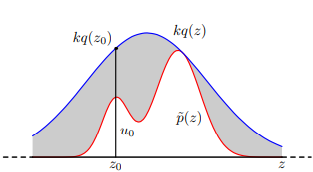

<sub> Figure taken from "Pattern Recognition and Machine Learning" (Christopher M. Bishop) </sub>

With reference to the figure above, the samples are rejected if they fall in the grey area between the unnormalized distribution $\tilde{p}(z)$ and the scaled distribution $kq(z)$. The accepted samples have uniform distribution under the curve of $\tilde{p}(z)$ and the corresponding values of $z$ will be distributed according to the desired target distribution $p(z)$.

The values of $z$, which are drawn from the proposal distribution $q(z)$ are accepted with probability $$\frac{\tilde{p}(z)}{kq(z)}$$ So, the overall probability of accepting a sample is: $$p(accept) = ∫ \frac{\tilde{p}(z)}{kq(z)} q(z) dz
          = \frac{1}{k} ∫ \tilde{p}(z) dz$$

Intuitively, the acceptance rate depends on the ratio between the area under the curve of the unnormalized distribution $\tilde{p}(z)$ and the area under the curve of the comparison function $kq(z)$: this tells us that the constant $k$ should be the smallest value satisfying $kq(z) \geq \tilde{p}(z)$.

#### In Practice 
As a practical illustration of Rejection Sampling, we will consider the implementation of the example proposed by Section 11.2.2 of Bishop's "Pattern Recognition and Machine Learning", i.e. the task of drawing samples from a Gamma distribution, defined as:
$$Gam(z|a, b) = \frac{b^a z^{a-1} exp(-bz)}{\Gamma(a)} $$
When $a>1$, the Gamma distribution has a bell-shaped form. A suitable choice for the proposal distribution is the Cauchy distribution, because it is also bell-shaped and can be sampled efficiently. We use a generalized form of the Cauchy, obtained by transforming a uniform random variable $y$ using $z = b \tan{y} + c$, which gives random numbers distributed according to $$q(z)=\frac{k}{1+(\frac{z-c}{b})^2} $$
As we said, the rejection rate is minimized by choosing the smallest $k$ satisfying $kq(z) \geq \tilde{p}(z)$ and, in particular, by setting $c = a − 1$ and $b^2 = 2a − 1$.


In [19]:
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, FloatSlider, IntSlider

# Base code generated by ChatGPT and edited (and commented)
def rejection_sampling_gamma(a=3.0, b=1.0, k=4.0, n_samples=10000):

    # Parameters set according to Bishop's example
    c = a - 1
    bc = np.sqrt(2 * a - 1)

    z_vals = []   # Candidate values
    u_vals = []   # Uniform values generated for comparison
    accepted_mask = []   # Boolean values indicating if each z was accepted
    accepted_samples = []   # List of accepted values


    # Iterate until n_samples values have been accepted
    while len(accepted_samples) < n_samples:

        # Generate a sample z from a Cauchy distribution centered in c and with scale bc
        # (Through inversion sampling)
        y = np.random.uniform(-np.pi / 2, np.pi / 2)
        z = bc * np.tan(y) + c

        # Gamma is defined by z > 0 -> negative samples are rejected
        if z <= 0:
            continue

        q_z = 1 / (np.pi * bc * (1 + ((z - c) / bc) ** 2))  # Value of the Cauchy proposal density
        p_z = z ** (a - 1) * np.exp(-b * z)  # Unnormalized Gamma target

        u = np.random.uniform(0, k * q_z) # Draw u from a uniform distribution between 0 and kq(z)
        accept = u < p_z  # Accept or reject sample

        # Store values for analysis and visualization
        z_vals.append(z)
        u_vals.append(u)
        accepted_mask.append(accept)
        if accept:
            accepted_samples.append(z)

    # Convert lists to NumPy arrays for easier handling 
    z_vals = np.array(z_vals)
    u_vals = np.array(u_vals)
    accepted_mask = np.array(accepted_mask)
    accepted_samples = np.array(accepted_samples)

    # 90th percentile of proposed values to avoid long tails and limit plot range
    z_max = np.percentile(z_vals, 90)

    # NumPy array containing containing 1000 equidistant values in 0.001 and z_max
    # x are the values over which we'll evaluate the functions
    x = np.linspace(0.001, z_max, 1000)

    p = x ** (a - 1) * np.exp(-b * x)  # Unnormalized Gamma target function

    q = 1 / (np.pi * bc * (1 + ((x - c) / bc) ** 2))  # Cauchy proposal function
    q_scaled = k * q  # proposal function scaled by k 

    # Histogram of accepted samples
    counts, bins = np.histogram(accepted_samples, bins=80, range=(0, z_max))
    bin_centers = 0.5 * (bins[:-1] + bins[1:])
    bin_width = bins[1] - bins[0]
    scale = np.trapz(p, x) / (len(accepted_samples) * bin_width) # To match the histogram with the unnormalized density p

    plt.figure(figsize=(8, 10))

    # First subplot: histogram + target + proposal
    plt.subplot(2, 1, 1)
    plt.bar(bin_centers, counts * scale, width=bin_width, alpha=0.6, label='Sampled')
    plt.plot(x, p, label=r'Target $\tilde{p}(z)$', color='blue')
    plt.plot(x, q_scaled, label=r'Scaled Proposal $kq(z)$', color='red', linestyle='--')
    plt.xlim(0, z_max)
    plt.xlabel("z")
    plt.ylabel("Density (scaled)")
    plt.title(f"Rejection Sampling")
    plt.legend()
    plt.grid(True)

    # Second plot: accepted vs rejected
    plt.subplot(2, 1, 2)
    plt.plot(x, p, label=r'Target $\tilde{p}(z)$', color='blue')
    plt.plot(x, q_scaled, label=r'Scaled Proposal $kq(z)$', color='red', linestyle='--')
    mask = z_vals <= z_max
    plt.scatter(z_vals[mask & ~accepted_mask], u_vals[mask & ~accepted_mask],
                color='red', alpha=0.4, s=10, label='Rejected')
    plt.scatter(z_vals[mask & accepted_mask], u_vals[mask & accepted_mask],
                color='green', alpha=0.4, s=10, label='Accepted')
    plt.xlim(0, z_max)
    plt.ylim(0, np.max(u_vals[mask]) * 1.1)
    plt.xlabel("z")
    plt.ylabel("u")
    plt.title("Accepted vs Rejected Samples")
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

# Interactive widget
interact(rejection_sampling_gamma,
         a=FloatSlider(value=3.0, min=1.1, max=10.0, step=0.1, description='a'),
         b=FloatSlider(value=1.0, min=0.1, max=5.0, step=0.1, description='b'),
         k=FloatSlider(value=4.0, min=1.0, max=10.0, step=0.1, description='k'),
         n_samples=IntSlider(value=10000, min=100, max=50000, step=100, description='n_samples'));


interactive(children=(FloatSlider(value=3.0, description='a', max=10.0, min=1.1), FloatSlider(value=1.0, descr…

As we can see from the graphs, varying the parameters $a$, $b$, $k$ and `n_samples` significantly affects the behavior of the Rejection Sampling process. 

The parameters $a$ and $b$ define the shape and scale of the target Gamma distribution and are set by default to two values satisfying the conditions that minimize the rejection rate. If they are altered, the changes affect how well the proposal distribution approximates the target, which clearly worsens the acceptance rate.

The parameter $k$ controls the vertical scaling of the proposal distribution. A larger $k$ increases the area between the scaled proposal curve and the target curve, which lowers the acceptance rate and the overall efficiency.

Finally, increasing `n_samples` requests more accepted samples before interrupting the sampling process: the final estimate will be closer to the target distribution, but, clearly, the computational cost will be higher.

### 1.3 - Adaptive Rejection Sampling
Often, defining a good proposal distribution $q(z)$ in advance is hard and applying Rejection Sampling is not feasible. Adaptive Rejection Sampling is an alternative approach in which, instead of defining the envelope function analytically, the envelope is built *dynamically*, using actual evaluations of the target distribution $p(z)$.

This method is especially effective when $p(z)$ is *log-concave*, meaning that $ln$ $p(z)$ is a concave function (in other words, it has derivatives that are nonincreasing functions of $z$).

The process works as follows:
1. Evaluate the function $ln$ $p(z)$ and its gradient at some initial set of grid points
2. At each of these points, compute the tangent lines to $ln$ $p(z)$
3. Use the intersections of the tangent lines to construct the envelope function
4. Draw a sample from this envelope instead of from $q(z)$
5. Apply the rejection sampling criterion to decide whether to accept or reject it:
   - If the sample is accepted, it’s treated as a valid sample from the target distribution
   - If the sample is rejected, it's added to the set of grid points and used to refine the envelope distribution (a new tangent line is computed at this point and the envelope is updated)

As the number of grid points increases, the envelope function becomes a better approximation of the desired distribution $p(z)$ and the probability of rejecting a sample decreases over time.  

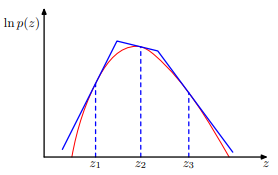

<sub> Figure taken from "Pattern Recognition and Machine Learning" (Christopher M. Bishop) </sub>

The Adaptive Rejection Sampling method can also be extended to distributions that are not log-concave by following each Rejection Sampling step with a Metropolis-Hastings step (Paragraph 2.2).

Clearly, to minimize the number of rejected samples and increase efficiency, the envelope should be a close match of the distribution function.

Note that ARS is not suited for problems of high dimensionality: the acceptance rate decreases exponentially when dimensionality increases, which is a generic feature of rejection sampling.

#### In Practice
The next example demonstrates how Adaptive Rejection Sampling works when sampling from a Gaussian distribution, which is a classic example of a log-concave distribution. We make use of the `ARSpy` library (see [documentation](https://arspy.readthedocs.io/en/latest/#)) and use an interactive widget to modify distribution parameters and visualize the target density, log-density, sampled histogram and the envelope function used by the algorithm.

> ##### Note:  
> As it is quite dated, the ARSpy library couldn't be installed via pip due to incompatibility issues. To make this piece of code work, follow these steps:
> - Manually download the library from [PyPI](https://pypi.org/project/ARSpy/)
> - Extract the contents and navigate to the sub-folder `arspy`
> - Copy it directly into the same directory as this Jupyter Notebook (be careful to copy it as it is and not nested inside of other folders)

As we know, the pdf of a Gaussian distribution is 
$$ p(z) = \frac{1}{\sqrt{2 \pi \sigma}} \exp{(-\frac{1}{2}(\frac{z-\mu}{\sigma})^2)} $$



In [20]:
import numpy as np
import matplotlib.pyplot as plt
from arspy.ars import adaptive_rejection_sampling
from ipywidgets import interact, FloatSlider
from scipy.stats import norm


# log-pdf for a Gaussian
def gaussian_logpdf(z, mu=0.0, sigma=2.0):
    return -0.5 * ((z - mu) / sigma) ** 2 - np.log(np.sqrt(2 * np.pi) * sigma)
    
# log-pdf's derivative
def gaussian_logpdf_derivative(z, mu=0.0, sigma=1.0):
    return -(z - mu) / (sigma ** 2)

def plot_ars(mu=0.0, sigma=1.0, n_support=5, n_samples=10000):
    # ARS sampling
    # The initial interval [a, b] is set to two standard deviations around the mean
    # As stated in ars.py, the derivative of log-pdf is not required as input to the sampler
    samples = adaptive_rejection_sampling(
        logpdf=lambda z: gaussian_logpdf(z, mu, sigma),
        a=mu - 2 * sigma, 
        b=mu + 2 * sigma,
        domain=(float("-inf"), float("inf")),
        n_samples=n_samples,
        seed=37
    )

    x = np.linspace(-8, 8, 500)
    
    # Compute the values of the Gaussian PDF
    pdf_vals = norm.pdf(x, loc=mu, scale=sigma)
    
    # Compute the corresponding log-PDF values
    logpdf_vals = gaussian_logpdf(x, mu, sigma)


    # Create 2 side by side subplots
    fig, (ax_pdf, ax_logpdf) = plt.subplots(1, 2, figsize=(14, 5))
    
    # Histogram of ARS samples + Gaussian PDF
    ax_pdf.hist(samples, bins=50, density=True, alpha=0.6, label='ARS Samples')
    ax_pdf.plot(x, norm.pdf(x, mu, sigma), 'r', label='Gaussian PDF')
    ax_pdf.set_title("Adaptive Rejection Sampling")
    ax_pdf.set_xlabel("z")
    ax_pdf.set_ylabel("Density")
    ax_pdf.legend()
    ax_pdf.grid(True)
    
    # Plot log-pdf and example of starting envelope
    # Build envelope with tangents 
    support_points = np.linspace(mu - 2*sigma, mu + 2*sigma, n_support)
    tangents = [gaussian_logpdf_derivative(s, mu, sigma) for s in support_points]
    logpdf_at_support = [gaussian_logpdf(s, mu, sigma) for s in support_points]

    envelope_lines = []
    # Compute tangents at every support point and store them
    for s, m, h in zip(support_points, tangents, logpdf_at_support):
        envelope_lines.append(h + m * (x - s))
    # Compute the upper envelope by comparing the arrays and selecting the minimum element-wise  
    envelope = np.minimum.reduce(envelope_lines)
    
    ax_logpdf.plot(x, gaussian_logpdf(x, mu, sigma), 'g--', label='log-PDF')
    ax_logpdf.plot(x, envelope, 'b-', label='Envelope')
    ax_logpdf.set_title("log-PDF + example of starting envelope")
    ax_logpdf.set_xlabel("z")
    ax_logpdf.set_ylabel("log-pdf")
    ax_logpdf.legend()
    ax_logpdf.grid(True)

    plt.tight_layout()
    plt.show()

# Interactive widget
interact(plot_ars,
         mu=FloatSlider(value=0.0, min=-3.0, max=3.0, step=0.1, description='μ'),
         sigma=FloatSlider(value=2.0, min=0.3, max=3.0, step=0.1, description='σ'),
         n_support=IntSlider(value=5, min=3, max=15, step=1, description='# supports'),
         n_samples=IntSlider(value=10000, min=500, max=20000, step=500, description='# samples'))


interactive(children=(FloatSlider(value=0.0, description='μ', max=3.0, min=-3.0), FloatSlider(value=2.0, descr…

<function __main__.plot_ars(mu=0.0, sigma=1.0, n_support=5, n_samples=10000)>

The plot on the left contains a histogram of the samples generated using ARS alongside the true Gaussian PDF, showing the quality of the approximation. 

The plot on the right displays the log of the target density, together with its initial upper envelope, formed by the tangents at selected support points.

As we know, $\mu$ and $\sigma$ represent the mean and standard deviation of the Gaussian distribution, and changing them shifts and scales the PDF and log-PDF curves accordingly, while the envelops adapts to the new shape of the log-PDF.

Changing the number of the initial supporting points used to build the tangents that form the envelope results in tighter or looser envelopes, showing how more support points lead to a more precise approximation, which consequently increases sampling efficiency.

As before, increasing the number of samples makes the histogram smoother and provides a more accurate estimate of the target PDF, at the expense of a higher computational cost.


### 1.4 - Importance Sampling
We already discussed in Paragraph 1 the reasoning behind wanting to calculate the expected value of some function $f(z)$ under a probability distribution $p(z)$, expressed as: 
$$ E[f] = ∫ f(z) p(z) dz$$ 
This integral may be too difficult to compute, which is why we would like to draw samples from $p(z)$ and then estimate the expectation as the average of these values: but, as we said when introducing Rejection Sampling, if $p(z)$ is not a standard distribution, sampling directly from it would be too complex. 

We could discretize $z$-space and use a uniform grid to evaluate the function across the space; however, this approach scales poorly in high dimensions.

As in the case of Rejection Sampling, Importance Sampling is based on the use
of a proposal distribution $q(z)$, chosen to be similar to $p(z)$, from which it's easy to draw samples. 

We can then express the expectation in the form of a finite sum over samples ${z^{(l)}
}$ drawn from $q(z)$: 
$$ E[f] = ∫ f(z) p(z) dz = ∫ f(z) \frac{p(z)}{q(z)} q(z) dz \simeq \frac{1}{L} \sum_{l=1}^{L} \frac{p(z^{(l)})}{q(z^{(l)})} f(z^{(l)}) $$
where the quantities $$r_l = \frac{p(z^{(l)})}{q(z^{(l)})}$$ are called *importance weights* and correct the bias introduced by sampling from a proposal distribution instead of the correct one.

Similarly to Rejection Sampling, in practice many times the value of $p(z)$ can be computed only up to a normalization constant $Z$: $$p(z) = \frac{1}{Z_p} \tilde{p}(z)$$ where $\tilde{p}(z)$ can be easily evaluated, but $Z_p$ is unknown. We assume the same for the proposal distribution $q(z)$, which can be written as $$q(z) = \frac{1}{Z_q} \tilde{q}(z)$$

We then proceed to rewrite the expectation in this form:
$$ E[f] = ∫ f(z) p(z) dz = \frac{Z_q}{Z_p}∫ f(z) \frac{\tilde{p}(z)}{\tilde{q}(z)} q(z) dz \simeq \frac{Z_q}{Z_p} \frac{1}{L} \sum_{l=1}^{L} \tilde{r}_l f(z^{(l)})$$
where $$\tilde{r}_l = \frac{\tilde{p}(z^{(l)})}{\tilde{q}(z^{(l)})}$$

If we also estimate the ratio $\frac{Z_q}{Z_p}$ using the same samples we obtain
$$\frac{Z_q}{Z_p} = \frac{1}{Z_q} ∫ \tilde{p}(z) dz = ∫ \frac{\tilde{p}(z)}{\tilde{q}(z)} dz \simeq \frac{1}{L} \sum_{l=1}^{L} \tilde{r}_l $$

and then we can rewrite the final weighted average as:
$$E[f] \simeq \sum_{l=1}^{L} w_l f(z^{(l)}) $$

where $$w_l = \frac{\tilde{r}_l}{\sum_{m} \tilde{r}_m} = \frac{\tilde{p}(z^{(l)})/q(z^{(l)})}{\sum_{m} \tilde{p}(z^{(m)})/q(z^{(m)}) } $$

Analogously to Rejection Sampling, the effectiveness of Importance Sampling strongly depends on how well the proposal distribution $q(z)$ matches the target distribution $p(z)$.

When the function $p(z)f(z)$ varies significantly and is concentrated in narrow regions of the space, if the proposal distribution $q(z)$ assigns them little probability, most importance weights will be nearly zero, with only a few having large values. As a result, small number of samples will dominate, reducing the effective sample size, and in extreme cases none of the samples fall in the high-probability regions, resulting in very inaccurate estimates, even if the sample variance appears small. This represents the major weakness of Importance Sampling: it can give misleading results without any indication that the estimate may be unreliable. 

To avoid this, it’s essential that $q(z)$ is not too small in areas where 
$p(z)f(z)$ is large.





#### In Practice
The distributions $p(z)$ and $q(z)$, along with the function $f(z)$, used in this example are a close match of the ones shown in the figure present in Bishop's _Pattern Recognition and Machine Learning_ 's paragraph about Importance Sampling.

> ###### Note: 
> Since `importance_sampling` is a very simple function, we can improve its modularity by using `scipy.stats`'s `rvs` (see [documentation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.norm.html)) to sample from the proposal $q(z)$ instead of manually sampling with `np.random.normal()`.

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from ipywidgets import interact, FloatSlider


# Bimodal target distribution p(z)
def p(z):
    return 0.6 * norm.pdf(z, loc=1.8, scale=0.3) + 0.4 * norm.pdf(z, loc=3.0, scale=0.3)

def f(z):
    return 1 / (1 + np.exp(-1.5 * (z - 2.4))) - 0.10

def importance_sampling(f, p, q_dist, n_samples=10000):
    samples = q_dist.rvs(size=n_samples)
    
    p_samples = p(samples)
    q_samples = q_dist.pdf(samples)
    weights = p_samples / q_samples
    f_samples = f(samples)
    
    estimate = np.mean(f_samples * weights)
    return estimate, samples, weights, f_samples

# Plotting code generated by ChatGPT
def plot_is(mu_q=2.4, sigma_q=0.75):
    z = np.linspace(-1, 5, 1000)
    q_dist = norm(loc=mu_q, scale=sigma_q)
    
    estimate, samples, weights, f_samples = importance_sampling(f, p, q_dist)
    
    p_z = p(z)
    q_z = q_dist.pdf(z)
    f_z = f(z)

    plt.figure(figsize=(10, 5))
    plt.plot(z, f_z, 'b', linewidth=2, label='f(z)')
    plt.plot(z, p_z, 'r', linewidth=2, label='p(z) (Target)')
    plt.plot(z, q_z, 'g', linewidth=2, label='q(z) (Proposal)')
    plt.title(f"Target vs Proposal")
    plt.xlabel("z")
    plt.ylabel("Value")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

    ax1.hist(samples, bins=50, weights=weights, density=True, alpha=0.6, label='Weighted Samples')
    ax1.plot(z, p_z, 'r', linewidth=2, label='p(z) (Target)')
    ax1.set_title("Importance Sampling")
    ax1.set_xlabel("z")
    ax1.set_ylabel("Density")
    ax1.legend()
    ax1.grid(True)

    ax2.hist(weights, bins=100, density=True, color='orange', alpha=0.7)
    ax2.set_title("Distribution of Importance Weights")
    ax2.set_xlabel("Weight value")
    ax2.set_ylabel("Density")
    ax2.grid(True)

    plt.tight_layout()
    plt.show()

interact(
    plot_is,
    mu_q=FloatSlider(value=2.4, min=1.5, max=3.5, step=0.05, description='μ'),
    sigma_q=FloatSlider(value=0.75, min=0.1, max=1.5, step=0.05, description='σ')
)


interactive(children=(FloatSlider(value=2.4, description='μ', max=3.5, min=1.5, step=0.05), FloatSlider(value=…

<function __main__.plot_is(mu_q=2.4, sigma_q=0.75)>

When $\mu = 2.40$ and $\sigma = 0.75$, the first plot matches the figure from Bishop’s book and shows the function $f(z)$ that we want to integrate, the target distribution $p(z)$ and the ideal choice of the proposal distribution $q(z)$ for this problem.

The second plot compares the histogram of the samples, drawn from $q(z)$ and adjusted using importance weights, to the target distribution $p(z)$. Clearly, the sampling process is effective when the samples closely match $p(z)$: this is the case when $q(z)$ is defined accordingly to the example of the book. 

The third plot shows the distribution of the importance weights, which reflect how much each sample contributes to the final estimate. When $q(z) = N(\mu = 2.40, \sigma = 0.75)$, most weights have moderate values, with few weights presenting near-zero or high values: many samples contribute meaningfully to the result of Importance Sampling, reducing the variance of the estimator and leading to a more reliable estimation.

By using the interactive widget to modify the mean $\mu$ and standard deviation $\sigma$ of the proposal distribution, we can observe how sensitive the method is to the choice of $q(z)$. 

If the proposal is centered away from one of the modes of $p(z)$, it generates fewer samples in that region, and a high number of weights, the great majority, will have near-zero values, i.e. they won't contribute to the final estimate, resulting in instability of the estimator.

If the standard deviation $\sigma$ of $q(z)$ is set too small, the proposal distribution becomes too narrow and does not cover the target distribution properly: many samples are drawn from irrelevant regions (where $p(z)≈0$), leading to many near-zero weights and a few large ones, and causing an increase in variance and the results to be unstable. However, if $\sigma$ is too large, $q(z)$ becomes too flat and places too many samples in regions where both $p(z)≈0$ and $f(z)≈0$: again, this leads to most samples having low importance and the sampling's efficiency being poor.

Ideally, the proposal should cover all the significant regions of $p(z)$ to ensure the weights stay moderate and the sampling remains efficient; in Bishop's case, the target $p(z)$ is bimodal, which results in the ideal positioning of $q(z)$ being in the center of its two modes.


### 1.5 - Sampling-Importance-Resampling
As discussed in Paragraph 1.2, Rejection Sampling's effectiveness relies on selecting a suitable constant $k$ such that $p(z) \leq kq(z)$ $\forall z$. However, finding it will be impractical for many pairs of distributions, especially when the required $k$ is large, because it will lead to a very low acceptance rate. 

The initial approach taken by SIR is similar to Rejection Sampling: it starts with a proposal distribution $q(z)$, but avoids the need to find a constant $k$.

The SIR method consists in two stages:
- *Sampling*: we draw L samples $z^{(1)}, ..., z^{(L)}$ from $q(z)$
- *Weighting and Resampling*: we construct L weights $w_1, ..., w_L$ using $$w_l = \frac{\tilde{r}_l}{\sum_{m} \tilde{r}_m} = \frac{\tilde{p}(z^{(l)})/q(z^{(l)})}{\sum_{m} \tilde{p}(z^{(m)})/q(z^{(m)}) } $$ then a second set of L samples is drawn from the discrete distribution $z^{(1)}, ..., z^{(L)}$ with probabilities given by the weights $(w_1, ..., w_L)$

The final set of resampled values only approximately follows the target distribution $p(z)$, but this approximation improves as $L→∞$, where  the cumulative distribution $p(z \leq a)$ of the resampled values converges to that of $p(z)$. This can be shown by expressing the cumulative probability as a weighted sum of indicator functions and observing that, taking the limit $L→∞$, the sum becomes an integral weighted according to the original sampling distribution $q(z)$, matching the cumulative distribution function of $p(z)$.

However, if we assume a finite value of $L$ and a given initial sample set, the resampled values will only be an appromixation of the values following the desired distribution. Again, as in the case of Rejection Sampling and Importance Sampling,  the approximation improves as the proposal distribution $q(z)$ gets closer to
$p(z)$. When $q(z) = p(z)$, the initial samples $z^{(1)}, ..., z^{(L)}$ have the desired distribution, and all weights become uniform ($w_i = 1/L$) so that resampling has no effect and the resampled values also have the desired distribution.

Additionally, if moments with respect to the distribution $p(z)$ are required, then they can be directly estimated from the original samples and their weights, without needing the resampled set, since $$ E[f] \simeq \sum_{l=1}^{L} w_l f(z_l) $$


#### In Practice
This example can be considered as an extension of the previous one on Importance Sampling.  

In addition to computing weighted samples from a proposal distribution using Importance Sampling, SIR adds a resampling step, in which a new set of samples is drawn according to the normalized importance weights.

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from ipywidgets import interact, FloatSlider, IntSlider


# Bimodal target distribution p(z)
def p(z):
    return 0.6 * norm.pdf(z, loc=1.8, scale=0.3) + 0.4 * norm.pdf(z, loc=3.0, scale=0.3)

def f(z):
    return 1 / (1 + np.exp(-1.5 * (z - 2.4))) - 0.10


def sir(f, p, q_dist, n_samples=10000):
    # Sampling according to Importance Sampling
    estimate, samples, weights, f_samples = importance_sampling(f, p, q_dist, n_samples)

    # Weight normalization
    norm_weights = weights / np.sum(weights)
    
    # Resampling: choose between initial samplings with probability proportional to normalized weights
    resampled_indices = np.random.choice(len(samples), size=n_samples, replace=True, p=norm_weights)
    resampled_samples = samples[resampled_indices]
    
    return estimate, samples, weights, resampled_samples


def plot_sir(mu_q=2.4, sigma_q=0.75, n_samples=10000):
    z = np.linspace(-1, 5, 1000)
    q_dist = norm(loc=mu_q, scale=sigma_q)
    
    estimate, samples, weights, resampled_samples = sir(f, p, q_dist, n_samples=n_samples)
    
    p_z = p(z)
    q_z = q_dist.pdf(z)
    f_z = f(z)
    
    # Plot Target, Proposal, and f(z)
    plt.figure(figsize=(10, 5))
    plt.plot(z, f_z, 'b', linewidth=2, label='f(z)')
    plt.plot(z, p_z, 'r', linewidth=2, label='p(z) (Target)')
    plt.plot(z, q_z, 'g', linewidth=2, label='q(z) (Proposal)')
    plt.title("Target vs Proposal")
    plt.xlabel("z")
    plt.ylabel("Value")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Weighted samples + resampled samples
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    ax1.hist(samples, bins=50, weights=weights, density=True, alpha=0.6, label='Weighted Samples')
    ax1.plot(z, p_z, 'r', linewidth=2, label='p(z)')
    ax1.set_title("Importance Sampling")
    ax1.set_xlabel("z")
    ax1.set_ylabel("Density")
    ax1.legend()
    ax1.grid(True)

    ax2.hist(resampled_samples, bins=50, density=True, alpha=0.6, color='orange', label='Resampled')
    ax2.plot(z, p_z, 'r', linewidth=2, label='p(z)')
    ax2.set_title("SIR")
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    plt.show()

    # Distribution of weights
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    ax1.hist(weights, bins=100, density=True, color='blue', alpha=0.7)
    ax1.set_title("Distribution of Importance Weights")
    ax1.set_xlabel("Weight value")
    ax1.set_ylabel("Density")
    ax1.grid(True)

    ax2.hist(weights / np.sum(weights), bins=50, density=True, color='purple', alpha=0.7)
    ax2.set_title("Normalized Importance Weights")
    ax2.set_xlabel("Weight value")
    ax2.set_ylabel("Density")
    ax2.grid(True)

    plt.tight_layout()
    plt.show()



interact(
    plot_sir,
    mu_q=FloatSlider(value=2.4, min=1.5, max=3.5, step=0.05, description='μ'),
    sigma_q=FloatSlider(value=0.75, min=0.1, max=1.5, step=0.05, description='σ'),
    n_samples=IntSlider(value=10000, min=100, max=50000, step=100, description='# samples')
)


interactive(children=(FloatSlider(value=2.4, description='μ', max=3.5, min=1.5, step=0.05), FloatSlider(value=…

<function __main__.plot_sir(mu_q=2.4, sigma_q=0.75, n_samples=10000)>

The first plot and the plots on the left (and the logic behind them) are exactly the same as the previous example shown in the Importance Sampling paragraph.

Instead, the first plot on the right shows the result of the SIR algorithm: compared to the Importance Sampling plot, it shows the resampled values. We can see that it provides a better approximation of the target distribution, especially as the number of samples increases.

Finally, the third set of plots illustrates the distribution of the weights: on the left we see the raw importance weights, while on the right it shows the normalized weights, which sum to one and represent the probabilities used for the resampling step.

### 1.6 - Sampling and The EM Algorithm
Monte Carlo sampling methods are not only useful in Bayesian analysis: they also assist in frequentist approaches. In particular, sampling methods can be used to approximate the E-step of the EM algorithm for models in which it cannot be performed analytically.

#### The General EM Algorithm
The Expectation-Maximization (EM) algorithm is a popular method for learning models with hidden (or latent) variables, used to find good parameter values for a probabilistic model when we have incomplete data.

EM works by alternating between two steps:
- The *E-step* (Expectation): estimate the missing or hidden parts of the data using the current model

- The *M-step* (Maximization): update the model parameters to better fit the data, assuming the estimated hidden parts are correct

This process repeats until the model stabilizes.

Formally:

> Given a joint distribution $p(X, Z|θ)$ over observed variables X and latent variables $Z$, governed by parameters $θ$, the goal is to maximize the likelihood function $p(X|θ)$ with respect to $θ$.
> 1. Choose an initial setting for the parameters $θ^{old}$.
> 2. *E-step*: Evaluate $p(Z|X, θ^{old})$.
> 3. *M-step*: Evaluate $θ^{new}$ given by $$θ^{new} = \arg \max_{θ} Q(θ, θ^{old})$$
where $$ Q(θ, θ^{old}) = ∫ p(Z|X, θ^{old}) \ ln \ p(X, Z|θ)\ dZ$$
> 4. Check for convergence of either the log likelihood or the parameter values.
If the convergence criterion is not satisfied, then let $$θ^{old} ← θ^{new}$$
and return to step 2.


However, in many cases the integral in Step 2 is intractable, we can approximate it using sampling: we draw $L$ samples ${Z^{(l)}}$ from the current estimate for the posterior distribution $p(Z∣X,θ^{old})$, and estimate $Q$ as:
$$ Q(θ, θ^{old}) \simeq \frac{1}{L} \sum_{l=1}^{L} ln \ p(Z^{(l)}∣X,θ)$$
Once the approximation is computed, the M-step proceeds normally to update the parameters. This procedure is called the *Monte Carlo EM Algorithm*.

#### Stochastic EM
A particular case is Stochastic EM, where only one sample is drawn during each E-step. This is useful for mixture models, where the hidden variable $Z$ indicates which mixture component generated each data point.
 
In this case:
- The E-step draws a sample from the posterior $p(Z∣X,θ^{old})$, assigning each data point to a component in the mixture
- The M-step uses this assignment to update the model parameters in the usual way

#### IP Algorithm
If we adopt a fully Bayesian perspective and aim to sample from the posterior distribution over the parameter vector $θ$, we ideally would like to draw samples from the joint posterior $p(θ, Z∣X)$. Suppose that this is computationally hard and that sampling from the complete-data parameter posterior $p(θ|Z, X)$ is relatively straightforward: we can use the *Data Augmentation* algorithm, also known as the IP (Imputation–Posterior) algorithm, which alternates between two steps, I and P, respectively analogous to the E-step and M-step, consisting in:

- *I-step*:  we wish to sample from $p(Z|X)$ but can't do it directly. But we can use the following relation: $$p(Z|X) = ∫ p(Z|θ, X)p(θ|X) dθ$$ to draw a sample $θ^{(l)}$ from the current estimate for $p(θ|X)$ and then use it to draw a sample $Z^{(l)}$ from $p(Z|θ^{(l)}, X) \  \forall \ l \in L$
  
- *P-step*: given the relation $$p(θ|X) = ∫ p(θ|Z, X)p(Z|X) dZ$$ we use the samples ${Z^{(l)}}$ obtained from the I-step to approximate the posterior over $θ$ as $$p(θ∣X) \simeq \frac{1}{L} \sum_{l=1}^{L} p(θ|Z^{(l)}, X)$$ from which we can sample, by assumption, in the next iteration.


***

## 2 - Markov Chain Monte Carlo

In the previous section, we discussed Rejection Sampling and Importance Sampling as methods for estimating expectations  of functions under a given probability distribution. However, both techniques tend to fail in high-dimensional spaces, where they become highly inefficient.

We now introduce a more flexible and powerful family of methods called *Markov Chain Monte Carlo (MCMC)*, which allow sampling from a large class of distributions and scale much better with dimensionality.

Again, as with Rejection and Importance Sampling, MCMC also uses a *proposal distribution* $q(\cdot)$ to generate samples. But this time, instead of sampling independently each time, we mantain a record of the current state $z^{(τ)}$: the proposal function $q(z|z^{(τ)})$ depends on this current state, resulting in a sequence of *dependent samples*, where the next sample depends on the current one. This new type of sequence, commonly known as *Markov chain*, has the property that each new state depends only on the current state $z^{(τ)}$, not on the full history of precedent states.

As before, if we write $p(z) = \tilde{p}(z) / Z_p$, we assume that $\tilde{p}(z)$ can easily be evaluated for any value of $z$ and that it isn't necessary to know the value of $Z_p$.  At each iteration of the algorithm, we generate a candidate sample $z^*$ based on the current state $z^{(τ)}$ from the proposal distribution $q(z^*|z^{(τ)})$, assuming that it is chosen easy to sample from, and then decide whether to accept or reject a sample according to an appropriate criterion.

#### The Metropolis Algorithm
A classical first example of a MCMC method is the Metropolis Algorithm, which works under the assumption that the proposal distribution is symmetric, i.e. $q(z_A|z_B) = q(z_B|z_A) \  \forall z_A, z_B$.

This symmetry simplifies the acceptance rule of the candidate sample, which is accepted with probability equal to:

$$ A(z^*,z^{(τ)}) = \min (1, \frac{\tilde{p}(z^*)}{\tilde{p}(z^{(τ)})}) $$

This can be achieved by drawing a random number $u∼Uniform(0,1)$ and by accepting the sample if $ A(z^*,z^{(τ)}) > u $. This means that if the candidate sample has a higher probability under $p(z)$ than the current one, it will always be accepted, but if it’s lower it still has a chance to be accepted. 

If the candidate sample is accepted, we set $z^{(τ+1)} = z^*$, otherwise we keep the current state, discard $z^*$, set $z^{(τ+1)} = z^{(τ)}$, and draw another candidate sample from the distribution $q(z|z^{(τ+1)})$. Note that this is different from Rejection Sampling, where we simply discarded the rejected sample: the Metropolis algorithm repeats the previous state and, as a result, the final sequence may contain repeated values. In practice, we only keep a single copy of each retained sample, along with a weight recording how many times that state appears. 

It is sufficient (but not necessary) that $q(z_A|z_B) > 0$ holds $\forall z_A, z_b$ for the chain to eventually produce samples $z^{(τ)}$ that approximate the true distribution $p(z)$, as the number of steps increases (i.e., as $τ→∞$). However, we should note that the sequence $z^{(1)}, z^{(2)}, ...$ is not composed of independent samples: each sample is highly correlated to the previous one. A common practice to obtain independent samples is to thin the chain by only keeping every $M$-th sample, where $M$ is large enough, and discarding all the others.


#### In Practice
See Paragraph 2.2's "In Practice" below for an implementation of the example in figure 11.9 of Bishop's book. 

### 2.1 - Markov Chains
Before introducing the Metropolis-Hastings Algorithm, it's useful to first understand the general behavior of Markov chains, especially the conditions under which they converge to a target distribution. In the precedent paragraph, we defined a first-order Markov chain as a sequence of random variables $z^{(1)}, ... , z^{(M)}$ where each variable depends only on its immediate predecessor, which formally translates to: $$ p(z^{(m+1)} | z^{(1)}, ... , z^{(m)}) = p(z^{(m+1)} | z^{(m)}) \ \forall  \ m \in \{ 1, ... , M - 1 \} $$

This structure can be visualized as a directed graph in the form of a chain which is fully specified by the probability distribution for the initial variable $p(z^{(0)})$ and its *transition probabilities* $T_m(z^{(m)}, z^{(m+1)}) \equiv p(z^{(m+1)}| z^{(m)})$, i.e. the conditional probabilities for subsequent variables. If these transition probabilities remain constant over time, the chain is called *homogeneous*.

The marginal probability of each state in the chain can be computed iteratively from the previous state using: $$p(z^{(m+1)}) = \sum_{z^{(m)}} p(z^{(m+1)}| z^{(m)}) p(z^{(m)}) $$

A distribution is called *invariant* (or stationary) with respect to a Markov chain if it does not change when we apply the transition rules. So, for a homogeneous chain with transition probabilities $T(z',z)$, a distribution $p^*(z)$ is invariant if:
$$ p^*(z) = \sum_{z'} T(z',z) p^*(z') $$
Note that a given Markov chain might have multiple invariant distributions: for example, if the chain never changes state (identity transitions), then any distribution will be invariant.

To ensure that a distribution $p(z)$ is invariant, one sufficient (but not necessary) condition is to satisfy the *detailed balance* property:
$$ p^*(z) T(z,z') = p^*(z') T(z',z)$$ 
If this condition is met, then the chain will leave the distribution $p^*(z)$ unchanged. A Markov chain that respects detailed balance is said to be *reversible*.

Our goal is to use Markov chains to sample from a given distribution. In addition to the desired distribution being invariant, we also require the chain to converge to this distribution regardless of the initial state: this convergence property is known as *ergodicity*,  and the invariant distribution is then called the *equilibrium distribution*. Note that an ergodic Markov chain has only one equilibrium distribution and that most homogeneous Markov chains will be ergodic, as the invariant distribution and the transition probabilities are only needed to meet weak conditions.

In practice, we often construct transition probabilities as combinations of simpler "base" transitions $B_1, ..., B_K$. This combination can be a mixture: 
$$ T(z',z) = \sum_{k=1}^{K} \alpha_k B_k(z',z) $$ where $\alpha_1, ..., \alpha_K$ are non-negative weights and $\sum_{k} \alpha_k = 1$, or a sequence of transitions:
$$T(z',z) = \sum_{z_1} ...  \sum_{z_{K-1}} B_1(z',z_1) ... B_{K-1}(z_{K-2},z_{K-1})B_K(z_{K-1},z)$$
If a distribution is invariant under each base transition, then it will also be invariant under the combined transition. In the mixture case, if each $B_K$ satisfies detailed balance, then $T$ does too. This does not hold for sequential transitions, which detailed balance can be preserved by applying transitions symmetrically ($B_1, B_2, ..., B_K, B_K, ..., B_2, B_1$).


### 2.2 - The Metropolis-Hastings Algorithm

We can generalize the Metropolis Algorithm, which was introduced in Paragraph 2, to the case where the proposal distribution is no longer a symmetric function of its arguments.

At each step $τ$, in which the current state is $z^{(τ)}$, a new candidate state $z^*$ is sampled from a proposal distribution $q_k(z∣z^{(τ)})$. This move is then accepted with probability:
$$ A_k(z^*,z^{(τ)}) = \min (1, \frac{\tilde{p}(z^*)q_k(z^{(τ)}|z^*)}{\tilde{p}(z^{(τ)})q_k(z^*,z^{(τ)})}) $$
where $k$ represents the elements of the set of possible transitions being considered. Again, the normalization constant $Z_p$ of the target distribution $p(z) = \tilde{p}(z) / Z_p$ is not required, since it cancels out in the acceptance ratio. If the proposal distribution is symmetric, this formula simplifies back to the original Metropolis rule.

We can show that $p(z)$ is an invariant distribution of the Markov chain defined
by the Metropolis-Hastings algorithm by showing that detailed balance property is satisfied:
$$
\begin{aligned}
p(z)q_k(z|z')A_k(z',z) &= \min \left(p(z)q_k(z|z'),\ p(z')q_k(z'|z)\right) \\
                       &= \min \left(p(z')q_k(z'|z),\ p(z)q_k(z|z')\right) \\
                       &= p(z')q_k(z'|z)A_k(z, z')
\end{aligned}
$$

The choice of proposal distribution significantly affects the algorithm’s performance. For continuous variables, a common choice is a *Gaussian* centered at the current state, but determining its variance parameter requires a trade-off. If the variance is too small most proposed states are accepted, but the chain moves slowly and it leads to high correlation between samples; however, if the variance is too large, many proposed steps will be to states for which the probability $p(z)$ is low, leading to a high rejection rate and resulting in slow convergence.

This trade-off becomes especially evident in high-dimensional problems with correlated variables. To optimize performance, the scale $𝜌$ of the proposal distribution should be of the same order as the smallest length scale $𝜎_{min}$ in the target distribution, i.e. big enough to explore the space efficiently, but not enough to result in high rejection rates. For instance, the time to generate approximately independent samples is of order $(𝜎_{max} /𝜎_{min}⁡)^2$, where $𝜎_{max}$ and $𝜎_{min}$ are the largest and smallest scales in the target distribution. 

In general, if the target distribution has very different scales in different directions, i.e. it varies a lot in different directions, Metropolis-Hastings might converge very slowly.

#### In Practice

Following Bishop's example, we will implement the Metropolis algorithm choosing a bivariate Gaussian distribution as our target. 

Since the Metropolis algorithm is a special case of Metropolis-Hastings, we will only write a general Metropolis-Hastings implementation, which can be used to demonstrate both cases: a symmetric proposal $q$ (corresponding to the classic Metropolis algorithm), and an asymmetric proposal $q$ (Metropolis-Hastings).

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
import ipywidgets as widgets
from ipywidgets import interact


# Target: bivariate Gaussian chosen to resemble the example in fig. 11.9 - Bishop
mu = np.array([0, 0])
Sigma = np.array([[1, 0.8], 
                  [0.8, 1]])
target = multivariate_normal(mean=mu, cov=Sigma)



def metropolis_hastings(p, q, q_density, z_0, n_samples=500):
    samples = [z_0]
    proposals = []
    z_current = z_0

    for _ in range(n_samples):
        z_proposed = q(z_current)

        proposals.append(z_proposed)

    	# If q is symmetric, alpha will be simplified to p(z_proposed) / p(z_current)
        alpha =  (
            p(z_proposed) * q_density(z_current, z_proposed)
            / (p(z_current) * q_density(z_proposed, z_current))
        )
 

        alpha = min(1, alpha)

        u = np.random.rand()
        if u < alpha:
            z_current = z_proposed

        samples.append(z_current)

    # Convert list to np.array for easier handling	
    return np.array(samples), np.array(proposals)


def plot_metropolis_hastings(p, q,q_density, n_samples=500, z0_choice="(-3,-3)"):
    
    # Mapping for starting points
    z0_map = {
        "(-3,-3)": np.array([-3.0, -3.0]),
        "(-3,3)": np.array([-3.0, 3.0]),
        "(3,-3)": np.array([3.0, -3.0]),
        "(3,3)": np.array([3.0, 3.0]),
    }
    z_0 = z0_map[z0_choice]


    # Run sampler
    samples, proposals = metropolis_hastings(p, q, q_density, z_0, n_samples)


    # Plotting code below generated by ChatGPT
    fig, ax = plt.subplots(figsize=(6, 6))

    # Ellipse of the target Gaussian	
    x, y = np.mgrid[-4:4:.01, -4:4:.01]
    pos = np.dstack((x, y))
    ax.contour(x, y, target.pdf(pos), levels=1, colors='k', alpha=0.5)

    # Draw path
    for i in range(len(proposals)):
        start, end = samples[i], proposals[i]
        accepted = np.allclose(samples[i+1], end)
        if accepted:
        	ax.plot([start[0], end[0]], [start[1], end[1]], color='g', linewidth=1, alpha=0.8)
        else:
        	ax.plot([start[0], end[0]], [start[1], end[1]], color='r', linewidth=1, alpha=0.3)


    ax.set_title(f"Metropolis-Hastings")
    ax.set_xlim(-4, 4)
    ax.set_ylim(-4, 4)
    plt.show()


##### Symmetric proposal function (Metropolis Algorithm)
Following Bishop's example, $q$ is an isotropic Gaussian with standard deviation equal to $0.2$.

In [17]:
from ipywidgets import fixed

# Symmetric proposal: isotropic Gaussian with std deviation of 0.2 as in Bishop's example
def q(z_current, sigma=0.2):
    return z_current + np.random.normal(scale=sigma, size=2)
 
def q_pdf(z_next, z_current, sigma=0.2):
    return multivariate_normal.pdf(
        z_next, mean=z_current, cov=sigma**2 * np.eye(2)
    )


# Interactive widget generated by ChatGPT
interact(
    plot_metropolis_hastings,
    p=fixed(target.pdf),
    q=fixed(q),
    q_density=fixed(q_pdf),
    n_samples=widgets.IntSlider(min=10, max=1500, step=10, value=500, description='# samples'),
    z0_choice=widgets.Dropdown(
        options=["(-3,-3)", "(-3,3)", "(3,-3)", "(3,3)"],
        value="(-3,-3)",
        description="z_0:"
    )
)


interactive(children=(IntSlider(value=500, description='# samples', max=1500, min=10, step=10), Dropdown(descr…

<function __main__.plot_metropolis_hastings(p, q, q_density, n_samples=500, z0_choice='(-3,-3)')>

The resulting figure shows the trajectory of a Metropolis sampler applied to a two-dimensional Gaussian target distribution with mean $(1.5, 1.5)$, whose one standard-deviation contour is shown by the ellipse (as we already said, the proposal distribution is an isotropic Gaussian distribution whose standard deviation is $0.2$). 

Accepted proposed steps correspond to green lines, where rejected proposals are shown in red. As expected, many of the rejected steps are towards regions of lower probability density (i.e. outside the ellipse), while most accepted steps are closer or within the high-density region. 

If we increase the number of samples, the accepted steps gradually form a cloud of points that approximates the target Gaussian and the chosen starting point becomes less influent.


##### Asymmetric proposal function (Metropolis-Hastings Algorithm)
In the asymmetric case, we choose $q$ as a Gaussian shifted by a fixed drift of
$0.5$ along the $x$-axis and with standard deviation equal to $0.5$. Thus, the symmetry of the proposal is broken: $\exists \, (z_A, z_B) \quad : \quad q(z_A|z_B) \neq q(z_B|z_A)$ .


In [18]:
# Asymmetric proposal: Gaussian with drift
def q(z_current, drift=np.array([0.5, 0]), sigma=0.5):
    return np.random.multivariate_normal(mean=z_current + drift, cov=sigma**2 * np.eye(2)) 

def q_pdf(z_next, z_current, drift=np.array([0.5, 0]), sigma=0.5):
    return multivariate_normal.pdf(z_next, mean=z_current + drift, cov=sigma**2 * np.eye(2))


# Interactive widget generated by ChatGPT
interact(
    plot_metropolis_hastings,
    p=fixed(target.pdf),
    q=fixed(q),
    q_density=fixed(q_pdf),
    n_samples=widgets.IntSlider(min=10, max=1500, step=10, value=800, description='# samples'),
    z0_choice=widgets.Dropdown(
        options=["(-3,-3)", "(-3,3)", "(3,-3)", "(3,3)"],
        value="(-3,-3)",
        description="z_0:"
    ),
)


interactive(children=(IntSlider(value=800, description='# samples', max=1500, min=10, step=10), Dropdown(descr…

<function __main__.plot_metropolis_hastings(p, q, q_density, n_samples=500, z0_choice='(-3,-3)')>

As before, accepted proposals are shown in green and rejected ones in red.

We can easily notice that, with the same number of steps, the number of rejected proposals is significantly larger compared to the symmetric case, and most rejected steps are towards the right, consistently with the drift of the proposal distribution, which pushes the chain in that direction.

However, as the number of samples increases, analogously to the symmetric case, the approximation of the target Gaussian gets more accurate and less influenced by the chosen starting point $z_0$ .

### Takeaways

We explored several sampling methods, starting from the theory and successively implementing interactive examples, following Bishop's treatment of the topic (contained in chapter 11 of the book). 

In summary, we learnt about the following methods:

- Inverse Transform Sampling: suited for standard distributions, where the CDF is known or can be numerically inverted.

- Rejection Sampling: useful for arbitrary and more complex distributions, but the efficiency strongly depends on the choice of the proposal distribution $q$ and the scaling constant $k$ .

- Adaptive Rejection Sampling: designed for log-concave target distributions, it exploits their log-concavity to build an adaptive proposal, making it more efficient compared to classic Rejection Sampling.

- Importance Sampling: estimates expectations under a target distribution by reweighting samples drawn from a simpler (thus more convenient) proposal distribution.

- Sampling-Importance-Resampling: adds a resampling step to Importance Sampling to improve the accuracy of the approximation.

- Metropolis-Hastings: general Markov Chain Monte Carlo method, useful to work with complex distributions.